<a href="https://colab.research.google.com/github/Singati2/AI_Science_Medicine/blob/main/Hahn_2023_AI_MNIST_Fully_Connected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/williamedwardhahn/mpcr
from mpcr import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-rjxxrjbb
  Running command git clone --filter=blob:none --quiet https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-rjxxrjbb
  Resolved https://github.com/williamedwardhahn/mpcr to commit 8d265643f3b8b6e0ed96c7fb98da047fdcd3bb51
  Preparing metadata (setup.py) ... done
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-py3-none-any.whl size=7664 sha256=84d7953d237a4d2bb4b6dbeb744981d924a17c4703e04e5449b93cd5d8c8beec
  Stored in directory: /tmp/pip-ephem-wheel-cache-2c5ph5rs/wheels/ea/02/e0/f5ddcc5cf9849058373052ecb328f3e9843fac4141b8491e0f
Successfully built ImportMPCR


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.utils

In [3]:
def plot(x):
    if type(x) == torch.Tensor :
        x = x.cpu().detach().numpy()

    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap = 'gray')
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [4]:
def montage_plot(x):
    x = np.pad(x, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)
    plot(montage(x))

In [5]:
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 32

In [6]:
#MNIST
train_set = datasets.MNIST('./data', train=True, download=True)
test_set = datasets.MNIST('./data', train=False, download=True)

#KMNIST
#train_set = datasets.KMNIST('./data', train=True, download=True)
#test_set = datasets.KMNIST('./data', train=False, download=True)

#Fashion MNIST
# train_set = datasets.FashionMNIST('./data', train=True, download=True)
# test_set = datasets.FashionMNIST('./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 95184450.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117379548.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25541760.46it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23175825.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
X = train_set.data.numpy()
X_test = test_set.data.numpy()
Y = train_set.targets.numpy()
Y_test = test_set.targets.numpy()
X = X[:,None,:,:]/255
X_test = X_test[:,None,:,:]/255
X = (X - 0.5)/0.5
X_test = (X_test - 0.5)/0.5

In [16]:
X.shape,Y.shape,X_test.shape,Y_test.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [17]:
###################################################

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Select GPU if available

def GPU(data):
    return torch.tensor(data, requires_grad=True, dtype=torch.float, device=device)

def GPU_data(data):
    return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)

In [19]:
X = GPU_data(X)
X_test = GPU_data(X_test)

Y = GPU_data(Y)
Y_test = GPU_data(Y_test)

<ipython-input-18-01725f96402a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)


In [20]:
X = (X + 1)/2
X_test = (X_test + 1)/2

In [21]:
def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:,:,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:,:,:]
        y = Y_test[r:r+b]
    return x,y

In [22]:
x,y = get_batch('train')

(array([20979.,   271.,   270.,   246.,   243.,   273.,   264.,   268.,
          283.,  1991.]),
 array([0.5       , 0.55000001, 0.60000002, 0.64999998, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.89999998, 0.94999999,
        1.        ]),
 <BarContainer object of 10 artists>)

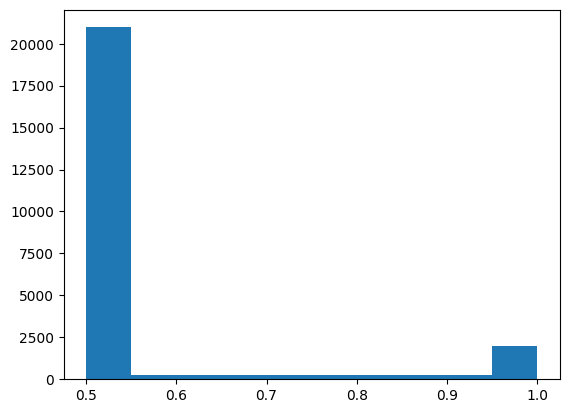

In [23]:
plt.hist(x.flatten().cpu().numpy())

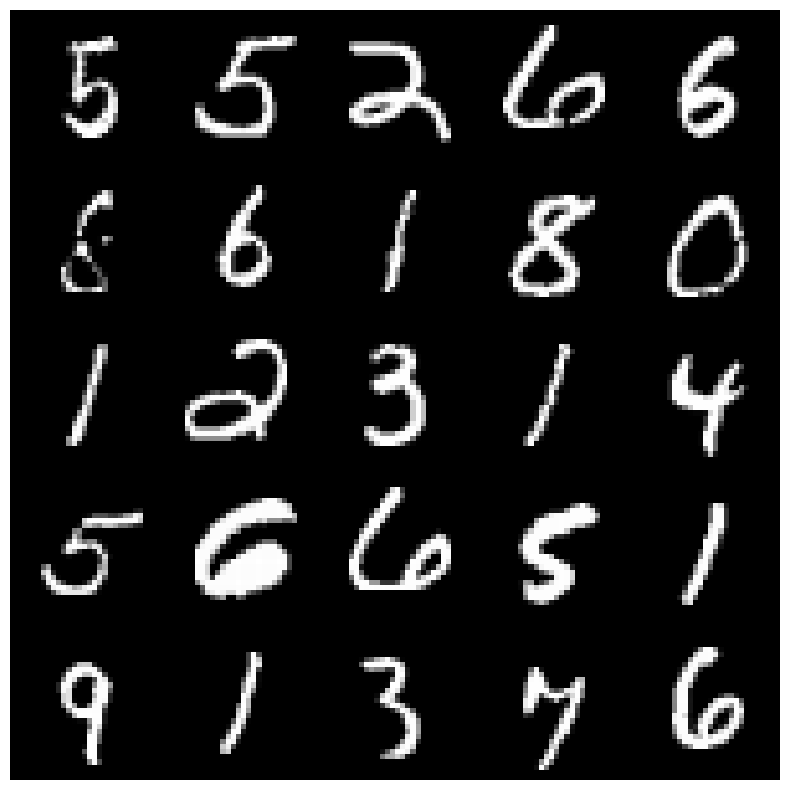

In [14]:
montage_plot(x[0:25,0,:,:].detach().cpu().numpy())

In [24]:
X = X.view(-1,784)
X_test = X_test.view(-1,784)

def get_batch(mode):
    b = batch_size
    if mode == "train":
        r = np.random.randint(X.shape[0]-b) 
        x = X[r:r+b,:]
        y = Y[r:r+b]
    elif mode == "test":
        r = np.random.randint(X_test.shape[0]-b)
        x = X_test[r:r+b,:]
        y = Y_test[r:r+b]
    return x,y

In [25]:
X.shape,X_test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [26]:
def softmax(x):
    s1 = torch.exp(x - torch.max(x,1)[0][:,None])
    s = s1 / s1.sum(1)[:,None]
    return s

In [27]:
def cross_entropy(outputs, labels):            
    return -torch.sum(softmax(outputs).log()[range(outputs.size()[0]), labels.long()])/outputs.size()[0]  

In [28]:
def randn_trunc(s): #Truncated Normal Random Numbers
    mu = 0 
    sigma = 0.1
    R = stats.truncnorm((-2*sigma - mu) / sigma, (2*sigma - mu) / sigma, loc=mu, scale=sigma)
    return R.rvs(s)

In [29]:
def acc(out,y):
    with torch.no_grad():
        return (torch.sum(torch.max(out,1)[1] == y).item())/y.shape[0]

In [30]:
def gradient_step(w):

    for j in range(len(w)): 

            w[j].data = w[j].data - c.h*w[j].grad.data
            
            w[j].grad.data.zero_()

In [31]:
def make_plots():
    
    acc_train = acc(model(x,w),y)
    
    xt,yt = get_batch('test')

    acc_test = acc(model(xt,w),yt)

    wb.log({"acc_train": acc_train, "acc_test": acc_test})

In [32]:
X = GPU_data(X)
Y = GPU_data(Y)
X_test = GPU_data(X_test)
Y_test = GPU_data(Y_test)

<ipython-input-18-01725f96402a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, requires_grad=False, dtype=torch.float, device=device)


In [33]:
def relu(x):
    return x * (x > 0)

In [34]:
relu(-5)

0

In [35]:
def model(x,w):

    for j in range(len(w)):

        x = relu(x@w[j])

    return x

In [36]:
def model(x,w):

    return relu(relu(x@w[0])@w[1])

In [37]:
def model(x,w):

    x = x@w[0]
    x = relu(x)
    x = x@w[1]
    x = relu(x)

    return x

In [ ]:
wb.init(project="Simple Fully Connected MNIST");
c = wb.config

c.h = 0.001
c.b = 100
c.layers = 2 
c.epochs = 100000

c.f_n = [784,500,10]

w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    loss.backward()

    gradient_step(w)
   
    if (i+1) % 1 == 0:

        make_plots()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
####With Adam Optimizer

In [ ]:
wb.init(project="Simple Fully Connected MNIST");
c = wb.config

c.h = 0.001
c.b = 1000
c.layers = 2 
c.epochs = 100000

c.f_n = [784,500,10]

w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

optimizer = torch.optim.Adam(w, lr=c.h)  

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if (i+1) % 1 == 0:

        make_plots()

In [ ]:
acc(model(X,w),Y)

In [ ]:
acc(model(X_test,w),Y_test)

0.5732

In [ ]:
model(X[0],w)

tensor([-0.0000, -0.0000, -0.0000, 42.5898, -0.0000, 99.4263, -0.0000, -0.0000,
        -0.0000, -0.0000], device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
torch.argmax(model(X[0],w))

tensor(5, device='cuda:0')

In [ ]:
Y[0]

tensor(5., device='cuda:0')

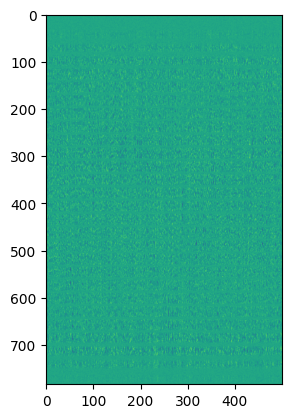

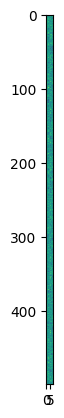

In [ ]:
for i in range(len(w)):

    plt.imshow(w[i].cpu().detach().numpy())
    plt.show()

In [ ]:
#CS Version

In [ ]:
X.shape

torch.Size([60000, 784])

In [ ]:
N = X.shape[1]
M = N//10;  #Samples

D = GPU_data(torch.randn(N,M))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [ ]:
D.shape

torch.Size([784, 78])

In [ ]:
X = torch.matmul(X,D)
X_test = torch.matmul(X_test,D)

In [ ]:
wb.init(project="Simple Fully Connected MNIST CS1");
c = wb.config

c.h = 0.01
c.b = 100
c.layers = 2 
c.epochs = 1000000

c.f_n = [M,500,500,10]

w = [ GPU(randn_trunc((c.f_n[i],c.f_n[i+1]))) for i in range(c.layers) ]

optimizer = torch.optim.Adam(w, lr=c.h)  

for i in range(c.epochs):

    x,y = get_batch('train')

    loss = cross_entropy(softmax(model(x,w)),y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    if (i+1) % 1 == 0:

        make_plots()

acc_test,0.59375
acc_train,0.625


acc_test,▁▄▂▅▃▃▆▄▄█▄▅█▅▆▆▆▆▆▇▆▅█▆▅▅▆▆▆▄▆▆▆█▆▆▅▇▇▇
acc_train,▁▂▃▃▂▄▃▅▆▇▇▅▇▅▅▆▅▆▅▆▆▆▇▆▆▇█▆▆▆▆▇▅▅▆▆▆▆▆▆
